<a href="https://colab.research.google.com/github/graceebc9/Arch_Class/blob/main/train_svi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train DCNN on facades for architecture Classification 


In [ ]:
!pip install wandb
import wandb
!pip install pytorch_lightning 
import pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.3/203.3 kB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.1 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=a84dd452913ba4e8685256b9b114094f6b5949c0584fd1dee55cc250a6cf68dc
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 33.9 MB/s

In [ ]:


#Store the PyTorch Lightning Data Modules and Model Classes 

import pytorch_lightning as pl
from pytorch_lightning import LightningDataModule ,Callback
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import WandbLogger
import wandb
from torch.utils.data import Dataset, DataLoader
from torchvision import  utils
import torchvision.transforms as T
import torchvision
import torchvision.models as models
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

torch.manual_seed(17)

import seaborn as sn
import matplotlib.pyplot as plt


from torchmetrics.classification import Accuracy, Recall
from torchmetrics import Precision, JaccardIndex, ConfusionMatrix
from torch.nn import  NLLLoss

import logging 

import numpy as np
import glob
import random

import sys
from PIL import Image
import PIL
import random
import os
import glob


from pytorch_lightning.callbacks import ModelCheckpoint

import torchvision.models as models
import torch
import pandas as pd
import wandb 
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import pytorch_lightning as pl


import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
base_dir = '/content/gdrive/MyDrive'

import sys
sys.path.insert(0, base_dir + '/HurricanDamage_Data')

from src import  ImagePredictionLogger, ImagePredictionLogger_table, extract_predictions

In [ ]:


import os
from typing import Tuple
import os
from typing import Optional
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

import torchvision.transforms as T

import torch
from torch.autograd import Variable as V
import torchvision.models as models
from torchvision import transforms as trn
from torch.nn import functional as F
import os
import pytorch_lightning as pl

import torch
import torch.nn as nn
import torchvision.models as models

import numpy as np
from typing import Optional

import os
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler



In [ ]:

gdf = pd.read_csv('/content/gdrive/MyDrive/Non_Trads_FOI/data/full_svi/gdf.csv')
gdf.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:

gdf.head()

,UPRN,Address,raw_Construction_type,Processed_Construction_Type,Other_Attributes,BRE_mapping_matches,BRE_Class,Latitude,Longitude,id_string,unique_id,latlong_id
0,1019030,36 HERTFORD ROAD Kettering,cornish,cornish,NaN,Cornish Unit Type I,PCC,52.380445,-0.715830,36 HERTFORD ROAD KetteringcornishPCC52.3804451...,77f9bf6a278eedb0a885afd3cb2461599c8b21a67a6dc8...,bb16f6ffaafd43370c7249fc87c4e271c030e3448d44ee...
1,1019052,38 HERTFORD ROAD Kettering,cornish,cornish,NaN,Cornish Unit Type I,PCC,52.380388,-0.715630,38 HERTFORD ROAD KetteringcornishPCC52.3803877...,03f9dceb5b7270f2bf4ab07a07c53cc1740b35b7b4be60...,a0150d9c1ae29738c7f34063e5a62dffcda87a624235dc...
2,1019063,40 HERTFORD ROAD Kettering,cornish,cornish,NaN,Cornish Unit Type I,PCC,52.380400,-0.715434,40 HERTFORD ROAD KetteringcornishPCC52.3804001...,751ee5f91b9c585a6413bb601a18d8c9f1bbd6044504cd...,aca3c54403965ccb9fd68a9ed64e3b24e97bf6c45a6b39...
3,1019085,42 HERTFORD ROAD Kettering,cornish,cornish,NaN,Cornish Unit Type I,PCC,52.380395,-0.715382,42 HERTFORD ROAD KetteringcornishPCC52.3803953...,50ad2f9eb902280589f3468843496ca84bc0772bfe6b3a...,559ef382202b9b3ed28e6457f025da354a02920d95b82e...
4,1019096,44 HERTFORD ROAD Kettering,cornish,cornish,NaN,Cornish Unit Type I,PCC,52.380358,-0.715236,44 HERTFORD ROAD KetteringcornishPCC52.3803576...,04ed396a7e8fdfc9b41ca9509115ae26d701b77559c770...,8d471ab3d2a1c995d53463dbfe0622c88a02e24297cfcd...


In [ ]:



class StreetViewData(Dataset):
    """
    Module for flexi data stored in flat structure with labels stored in gdf dataframe 
    """
    def __init__(self, root_dir: str, pred_only: bool, transform: Optional[transforms.Compose] = None, svi_raw: bool = True ):
        
        self.root_dir = root_dir
        self.transform = transform
        self.pred_only= pred_only 
        self.svi_raw = svi_raw
        self.corrupt_samples = []
        type_sv = 'brand' # bre_class

        if type_sv == 'brand':
          top_classes = ['Wimpey No-Fines',
                        'Reema Conclad',
                        'BISF Type A1',
                        'Mowlem',
                        # 'Timber Frame (UK)',
                        'Orlit Type I',
                        'Easiform Type I',
                        'Wates',
                        'Weir No-Fines',
                        'Blackburn',
                        'Cornish Unit Type I',
                        'Airey',
                        # 'Concrete   ',
                        # 'Bison Trimline',
                        'Unity Type I',
                        # 'Shepherd',
                        # 'EDLO BRS',
                        'Parkinson',
                        # 'Aberdeen Corporation',
                        # 'Belfry'
                        ]
          groupin_col = 'BRE_mapping_matches'
        
        elif type_sv =='bre_class':
          top_classes =['PCC', 'ISC', 'TIM', 'MET']
          groupin_col = 'BRE_Class'
        else:
          print('error - which grouping? ')
      
        #Get all samples from directory 
        grouped = gdf.groupby(['Latitude', 'Longitude', 'latlong_id'])[groupin_col].agg(lambda x:x.value_counts().index[0]).reset_index()
        self.samples = []
        self.list_samples = os.listdir(self.root_dir) 
        print('list of raw samples is {}'.format(len(self.list_samples) ))

        if self.pred_only is False:
          ids = [x.split('_')[0] for x in self.list_samples] 
          labels = [ grouped[grouped['latlong_id'] == x][groupin_col].values  for x in ids ]
        else:
          self.list_samples = [x for x in self.list_samples if x[-4:] =='.jpg' ]
          ids = [x.split('_')[0] for x in self.list_samples] 
          labels = ['-999' for x in ids]
          
        #Create classes and class weights   
        
        samples_df = grouped[(grouped['latlong_id'].isin(ids) )& (  grouped['BRE_mapping_matches'].isin(top_classes)) ]
        counts = samples_df.groupby('BRE_mapping_matches').count()['Latitude'].tolist()
        
        

        self.classes = samples_df.groupby('BRE_mapping_matches').count().index.tolist()
        print(self.classes)
        print(counts)
        weights = [1/x for x in counts] 
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.idx_to_classes = {str(i): cls_name for i, cls_name in enumerate(self.classes)}
        print(self.classes)
        

        self.class_weights_dict = {}
        for (k, _) ,v in zip(enumerate(self.classes), weights):
            self.class_weights_dict[k]=v
        
        print(self.class_weights_dict)

        #Load samples 
        for s, label in zip(self.list_samples, labels) :
            if self.pred_only is False:
              if label in top_classes:
                    sample_path = os.path.join(self.root_dir, s)
                    if not os.path.exists(sample_path):
                        None
                    else:
                        self.samples.append((sample_path, self.class_to_idx[label[0]]))
              
            else:
              sample_path = os.path.join(self.root_dir, s)
              if not os.path.exists(sample_path):
                    None
              else:
                    self.samples.append((sample_path, label))
        print('len samples : {}'.format(len(self.samples) ))        


    def classes_dict(self):
      return self.idx_to_classes

    def __len__(self):
        # return len(self.samples) 
        return len(self.samples) - len(self.corrupt_samples)

    

    def __getitem__(self, index):
        
        sample_path, label = self.samples[index]
        try:
          with open(sample_path, "rb") as f:
              sample = Image.open(f).convert("RGB")
              if self.svi_raw ==True:
                  left = 170
                  top = 250
                  right = 430
                  bottom = 10
                  sample =  sample.crop((left, bottom, right, top))
        except PIL.UnidentifiedImageError:
            print('image error')
            # log the corrupt sample path
            logging.warning(f"Corrupt image file: {sample_path}")
            # add the corrupt sample to the list
            self.corrupt_samples.append(index)
            # skip the corrupt sample and return None
            return None
            

        if self.transform:
            sample = self.transform(sample)
        if self.pred_only is True:
          return sample 
        else:
          return sample, label 
    
    def get_list_samples(self):
        return self.samples

    def get_idx_to_classes(self):
      return self.idx_to_classes
    

        


class MyDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size, num_workers=4, pred_only=False, svi_raw = True):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        resize = 299 # 224 resnet 
        # self.transform = T.Compose([ T.Resize( size = (224, 224) ),
        #                             T.ToTensor() ])       
       
        mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
        self.transform = T.Compose( [
            transforms.Resize(size=(resize, resize)),
            transforms.ToTensor(),
            transforms.Normalize(mean ,std ) 
        ])
        self.train_transforms = T.Compose( [
           
            transforms.RandomRotation(30),
            transforms.RandomHorizontalFlip(),
            
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 2.0)),
            # transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3)),
            transforms.Resize(size=(resize, resize)),
            transforms.ToTensor(),
            transforms.Normalize(mean ,std ) 
        ])
        self.pred_only = pred_only
        self.svi_raw = svi_raw
        # only apply extra transformations to the train data 
        self.dataset = StreetViewData(data_dir, transform = self.transform, pred_only =  self.pred_only, svi_raw = self.svi_raw)
        self.train_dataset = StreetViewData(data_dir, transform = self.train_transforms, pred_only =  self.pred_only, svi_raw = self.svi_raw)


    def setup(self, stage=None): 
        num_samples = len(self.dataset)
        print('num samples {}'.format(num_samples))
        indices = list(range(num_samples))
        split_train = int(np.floor(0.7 * num_samples))
        split_val = int(np.floor(0.15 * num_samples))
        np.random.shuffle(indices)
        train_indices, val_indices, test_indices = indices[:split_train], indices[split_train:split_train+split_val], indices[split_train+split_val:]
        
        
        if self.pred_only is False:
          print('Num train:{} Num val:{} Num test:{}'.format(len(train_indices), len(val_indices), len(test_indices)) )
          print('Total num: {}  total sum: {}'.format(num_samples, (len(train_indices)+ len(val_indices)+ len(test_indices))))
        
        # create subdatasets
        train_dataset = torch.utils.data.Subset(self.train_dataset, train_indices)
        val_dataset = torch.utils.data.Subset(self.dataset, val_indices)
        test_dataset = torch.utils.data.Subset(self.dataset, test_indices)

        #create classes and weights
        print('starting labels')
        train_labels = []
        for data in train_dataset:
            label = data[1]   # assuming label is the second element of each data point
            train_labels.append(label)
        train_weights = [self.dataset.class_weights_dict[i] for i in train_labels]
        
        
        # define samplers
        print('starting samplers')
        # val_sampler = SubsetRandomSampler(val_indices)
        train_sampler = torch.utils.data.WeightedRandomSampler(train_weights, num_samples = len(train_weights) )
        
        # set up data loaders
        self.train_loader = DataLoader(train_dataset, batch_size=self.batch_size, sampler=train_sampler, num_workers=self.num_workers)
        self.val_loader = DataLoader(val_dataset, batch_size=self.batch_size, num_workers=self.num_workers)

        # test_sampler = SubsetRandomSampler(test_indices)
        self.test_loader = DataLoader(test_dataset, batch_size=self.batch_size,  num_workers=self.num_workers)
    
        print('Data modules for predict only')
        if self.pred_only is True:
          print('Pred only, num of samples = {}'.format(num_samples) )
        self.predict_loader = DataLoader(self.dataset, batch_size=self.batch_size, num_workers=self.num_workers)
    
                                       


    def train_dataloader(self):
        return self.train_loader

    def val_dataloader(self):
        return self.val_loader

    def test_dataloader(self):
        return self.test_loader
    
    def predict_dataloader(self):
        return self.predict_loader
  

    def get_dataset_samples(self):
        #pull list of samples from SVi dataset 
        return self.dataset.get_list_samples()
    def get_dataset_dict(self):
        #pull list of samples from SVi dataset 
        return self.dataset.get_idx_to_classes()





In [ ]:



class TransferLearning(pl.LightningModule):
    """
        Transfer learning data modules, works for ResNet Architectures 
        model: pytorch Resnet18 / 50 etc 
    """

    def __init__(self, model, learning_rate, optimiser = 'Adam', class_names=None, num_classes = None):
        super().__init__()
        
        self.optimiser = optimiser
        self.thresh  =  0.5
        self.save_hyperparameters()
        self.learning_rate = learning_rate
        self.class_names = class_names
        self.num_classes = len(self.class_names)
        
        #add metrics for tracking 
        self.accuracy = Accuracy(task= 'multiclass', num_classes=self.num_classes)
        self.loss= nn.CrossEntropyLoss()
        self.recall = Recall(task= 'multiclass', num_classes=self.num_classes, threshold=self.thresh, average ='macro')
        self.prec = Precision( task= 'multiclass', num_classes=self.num_classes, average='macro')
        self.jacq_ind = JaccardIndex(task= 'multiclass', num_classes=self.num_classes)
        self.confmat = ConfusionMatrix(task="multiclass", num_classes=self.num_classes)


        # init model
        backbone = model
        num_filters = backbone.fc.in_features
        layers = list(backbone.children())[:-1]
        self.feature_extractor = nn.Sequential(*layers)

        # use the pretrained model to classify damage 2 classes
        
        self.classifier = nn.Linear(num_filters, self.num_classes)

    def forward(self, x):
        self.feature_extractor.eval()
        with torch.no_grad():
            representations = self.feature_extractor(x).flatten(1)
        x = self.classifier(representations)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss(logits, y)
        
        # training metrics
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, y)
        recall = self.recall(preds, y)
        precision = self.prec(preds, y)
        jac = self.jacq_ind(preds, y)
        

        wandb.log({"train_loss": loss})   
        self.log('train_loss', loss, on_step=True, on_epoch=True, logger=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, logger=True)
        self.log('train_recall', recall, on_step=True, on_epoch=True, logger=True)
        self.log('train_precision', precision, on_step=True, on_epoch=True, logger=True)
        self.log('train_jacc', jac, on_step=True, on_epoch=True, logger=True)
        
        return loss
  
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss(logits, y)

        # validation metrics
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, y)
        recall = self.recall(preds, y)
        precision = self.prec(preds, y)
        jac = self.jacq_ind(preds, y)
        self.confmat.update(preds, y)
        
        

        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        self.log('val_recall', recall, prog_bar=True)
        self.log('val_precision', precision, prog_bar=True)
        self.log('val_jacc', jac, prog_bar=True)
        
        return  loss
      

    def on_validation_epoch_end(self):
        confmat = self.confmat.compute()
        class_names = self.class_names
        num_classes = len(class_names)

        df_cm = pd.DataFrame(confmat.cpu().numpy() , index = [i for i in class_names], columns = [i for i in class_names])
        df_cm.to_csv('raw_nums.csv') # used this to validate the number of val samples
        print('Num of val samples: {}. Check this aligns with the numbers from the dataloader'.format(df_cm.sum(axis=1).sum() ))
        #normalise the confusion matrix 
        norm =  np.sum(df_cm, axis=1)
        normalized_cm = (df_cm.T/norm).T
        #validate the confusion matrix sums to num of classes
       
          

        normalized_cm.to_csv('norm_cdf.csv') 
        #log to wandb
        f, ax = plt.subplots(figsize = (15,10)) 
        sn.heatmap(normalized_cm, annot=True, ax=ax)
        wandb.log({"Validation Confusion Matrix ": wandb.Image(f) })
        self.confmat.reset()  #This was NEEDED otherwise the confusion matrix kept stacking the results

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss(logits, y)
        
        # validation metrics
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, y)
        recall = self.recall(preds, y)
        precision = self.prec(preds, y)
        jac = self.jacq_ind(preds, y)
        # confmat = self.confmat(preds, y)

        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)
        self.log('test_recall', recall, prog_bar=True)
        self.log('test_precision', precision, prog_bar=True)
        self.log('test_jacc', jac, prog_bar=True)
         
        # self.log('test_conf', confmat, on_step=False, on_epoch=True, logger=True)

        return loss

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x = batch
        logits = self(x)
        preds = torch.argmax(logits, dim=1) 
        return preds, x

    def configure_optimizers(self,):
        print('Optimise with {}'.format(self.optimiser) )
        # optimizer = self.optimiser_dict[self.optimiser](self.parameters(), lr=self.learning_rate)
                
                # Support Adam, SGD, RMSPRop and Adagrad as optimizers.
        if self.optimiser == "Adam":
            optimiser = optim.AdamW(self.parameters(), lr = self.learning_rate)
        elif self.optimiser == "SGD":
            optimiser = optim.SGD(self.parameters(), lr = self.learning_rate)
        elif self.optimiser == "Adagrad":
            optimiser = optim.Adagrad(self.parameters(), lr = self.learning_rate)
        elif self.optimiser == "RMSProp":
            optimiser = optim.RMSprop(self.parameters(), lr = self.learning_rate)
        else:
            assert False, f"Unknown optimizer: \"{self.optimiser}\""

        return optimiser


In [ ]:

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False    

In [ ]:

class TransferLearning_Ince(pl.LightningModule):
    """
    Transfer leaning module for Inception V3 architecture 
    """
    def __init__(self, learning_rate, optimiser = 'Adam', av_type = 'macro', class_names=None, ):
        super().__init__()
        # self.class_weights = torch.FloatTensor(weights)
        self.optimiser = optimiser
        self.thresh  =  0.5
        self.save_hyperparameters()
        self.learning_rate = learning_rate
        self.class_names = class_names
        self.num_classes = len(class_names )
        
        # #add metrics for tracking 
        # self.accuracy = Accuracy()
        # self.loss= nn.CrossEntropyLoss()
        # self.recall = Recall(num_classes=self.num_classes, threshold=self.thresh, average = av_type)
        # self.prec = Precision( num_classes=self.num_classes, average = av_type )
        # self.jacq_ind = JaccardIndex(num_classes=2)

                
        #add metrics for tracking 
        self.accuracy = Accuracy(task= 'multiclass', num_classes=self.num_classes)
        self.loss= nn.CrossEntropyLoss()
        self.recall = Recall(task= 'multiclass', num_classes=self.num_classes, threshold=self.thresh, average ='macro')
        self.prec = Precision( task= 'multiclass', num_classes=self.num_classes, average='macro')
        self.jacq_ind = JaccardIndex(task= 'multiclass', num_classes=self.num_classes)
        self.confmat = ConfusionMatrix(task="multiclass", num_classes=self.num_classes)

        
        #Parameters for Inception V3
        feature_extract = True  #model finetunes and all features updated , if feature = True; only last layer will be updated 
        
        model_ft = models.inception_v3(pretrained=True)
        set_parameter_requires_grad(model_ft, feature_extract)
        #handle auxilliary net 
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, self.num_classes)
        #handle primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, self.num_classes)
        self.model = model_ft
        print(self.model)

    def forward(self, x):
        output  = self.model(x) 
        return output
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits , aux_outputs = self(x)
        loss1 = self.loss(logits, y)
        loss2 = self.loss(aux_outputs, y )
        loss = loss1 + 0.4*loss2
        
        # training metrics
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, y)
        recall = self.recall(preds, y)
        precision = self.prec(preds, y)
        jac = self.jacq_ind(preds, y)

        self.log('train_loss', loss, on_step=True, on_epoch=True, logger=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, logger=True)
        self.log('train_recall', recall, on_step=True, on_epoch=True, logger=True)
        self.log('train_precision', precision, on_step=True, on_epoch=True, logger=True)
        self.log('train_jacc', jac, on_step=True, on_epoch=True, logger=True)
        return loss
  
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits  = self(x)
        loss = self.loss(logits, y)

        # validation metrics
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, y)
        recall = self.recall(preds, y)
        precision = self.prec(preds, y)
        jac = self.jacq_ind(preds, y)


        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        self.log('val_recall', recall, prog_bar=True)
        self.log('val_precision', precision, prog_bar=True)
        self.log('val_jacc', jac, prog_bar=True)
        self.confmat.update(preds, y)

        return loss
    def on_validation_epoch_end(self):
        confmat = self.confmat.compute()
        class_names = self.class_names
        num_classes = len(class_names)

        df_cm = pd.DataFrame(confmat.cpu().numpy() , index = [i for i in class_names], columns = [i for i in class_names])
        df_cm.to_csv('raw_nums.csv') # used this to validate the number of val samples
        print('Num of val samples: {}. Check this aligns with the numbers from the dataloader'.format(df_cm.sum(axis=1).sum() ))
        #normalise the confusion matrix 
        norm =  np.sum(df_cm, axis=1)
        normalized_cm = (df_cm.T/norm).T
        #validate the confusion matrix sums to num of classes
       
          

        normalized_cm.to_csv('norm_cdf.csv') 
        #log to wandb
        f, ax = plt.subplots(figsize = (15,10)) 
        sn.heatmap(normalized_cm, annot=True, ax=ax)
        wandb.log({"Validation Confusion Matrix ": wandb.Image(f) })
        self.confmat.reset()  #This was NEEDED otherwise the confusion matrix kept stacking the results


    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss(logits, y)
        
        # validation metrics
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, y)
        recall = self.recall(preds, y)
        precision = self.prec(preds, y)
        jac = self.jacq_ind(preds, y)


        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)
        self.log('test_recall', recall, prog_bar=True)
        self.log('test_precision', precision, prog_bar=True)
        self.log('test_jacc', jac, prog_bar=True)

        return loss
    
    def configure_optimizers(self,):
        print('Optimise with {}'.format(self.optimiser) )
        # optimizer = self.optimiser_dict[self.optimiser](self.parameters(), lr=self.learning_rate)
                
                # Support Adam, SGD, RMSPRop and Adagrad as optimizers.
        if self.optimiser == "Adam":
            optimiser = optim.Adam(self.parameters(), lr = self.learning_rate)
        elif self.optimiser == "SGD":
            optimiser = optim.SGD(self.parameters(), lr = self.learning_rate)
        elif self.optimiser == "Adagrad":
            optimiser = optim.Adagrad(self.parameters(), lr = self.learning_rate)
        elif self.optimiser == "RMSProp":
            optimiser = optim.RMSprop(self.parameters(), lr = self.learning_rate)
        else:
            assert False, f"Unknown optimizer: \"{self.optimiser}\""

        return optimiser

# Train Model 

In [ ]:
top_classes = ['Wimpey No-Fines',
                        'Reema Conclad',
                        'BISF Type A1',
                        'Mowlem',
                        # 'Timber Frame (UK)',
                        'Orlit Type I',
                        'Easiform Type I',
                        'Wates',
                        'Weir No-Fines',
                        'Blackburn',
                        'Cornish Unit Type I',
                        'Airey',
                        # 'Concrete   ',
                        'Bison Trimline',
                        'Unity Type I',
                        'Shepherd',
                        'EDLO BRS',
                        'Parkinson',
                        'Aberdeen Corporation',
                        'Belfry']

top_classes = ['Wimpey No-Fines',
                        'Reema Conclad',
                        'BISF Type A1',
                        'Mowlem',
                        # 'Timber Frame (UK)',
                        'Orlit Type I',
                        'Easiform Type I',
                        'Wates',
                        'Weir No-Fines',
                        'Blackburn',
                        'Cornish Unit Type I',
                        'Airey',
                        # 'Concrete   ',
                        # 'Bison Trimline',
                        'Unity Type I',
                        # 'Shepherd',
                        # 'EDLO BRS',
                        'Parkinson',
                        # 'Aberdeen Corporation',
                        # 'Belfry'
                        ]

In [ ]:

rdir= "/content/gdrive/MyDrive/Non_Trads_FOI/data/full_svi/all_images"
samp = os.listdir(rdir) 

In [ ]:

ids = [x.split('_')[0] for x in samp]

<Axes: xlabel='BRE_mapping_matches'>

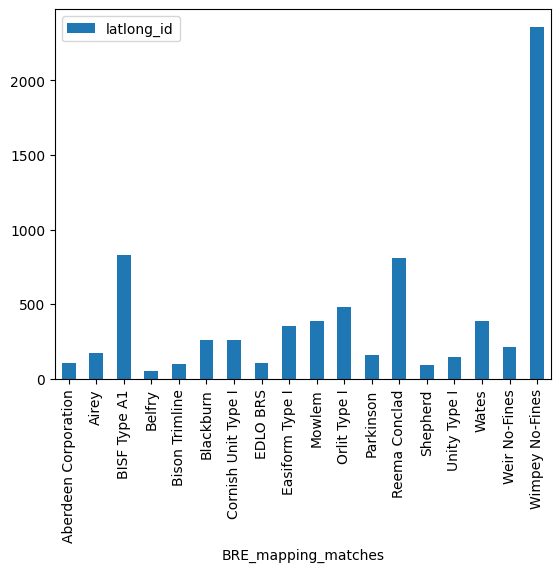

In [ ]:

gdf[(gdf['BRE_mapping_matches'].isin(top_classes))& (gdf['latlong_id'].isin(ids)) ][['latlong_id', 'BRE_mapping_matches']].drop_duplicates().groupby('BRE_mapping_matches').count().plot(kind='bar')

In [ ]:
#this method gets all the list of samples 
len(dm.get_dataset_samples())

6825

In [ ]:

dm = MyDataModule(data_dir="/content/gdrive/MyDrive/Non_Trads_FOI/data/full_svi/all_images", batch_size=32)
dm.setup()

train_dataloader = dm.train_dataloader()
val_dataloader = dm.val_dataloader()

list of raw samples is 8853
['Airey', 'BISF Type A1', 'Blackburn', 'Cornish Unit Type I', 'Easiform Type I', 'Mowlem', 'Orlit Type I', 'Parkinson', 'Reema Conclad', 'Unity Type I', 'Wates', 'Weir No-Fines', 'Wimpey No-Fines']
[175, 828, 260, 255, 355, 386, 481, 161, 809, 143, 385, 212, 2356]
['Airey', 'BISF Type A1', 'Blackburn', 'Cornish Unit Type I', 'Easiform Type I', 'Mowlem', 'Orlit Type I', 'Parkinson', 'Reema Conclad', 'Unity Type I', 'Wates', 'Weir No-Fines', 'Wimpey No-Fines']
{0: 0.005714285714285714, 1: 0.0012077294685990338, 2: 0.0038461538461538464, 3: 0.00392156862745098, 4: 0.0028169014084507044, 5: 0.0025906735751295338, 6: 0.002079002079002079, 7: 0.006211180124223602, 8: 0.0012360939431396785, 9: 0.006993006993006993, 10: 0.0025974025974025974, 11: 0.0047169811320754715, 12: 0.00042444821731748726}
len samples : 6825
list of raw samples is 8853
['Airey', 'BISF Type A1', 'Blackburn', 'Cornish Unit Type I', 'Easiform Type I', 'Mowlem', 'Orlit Type I', 'Parkinson', 'Reem

In [ ]:
#Parameters set for our Final Model config; using ResNet50 architecture
bs = 160
LR = 0.006607
optimiser = 'Adam'


model = TransferLearning(model=models.resnet50(weights='DEFAULT'), learning_rate = LR, optimiser = optimiser, class_names = dm.dataset.classes  ) #


# model = TransferLearning_Ince(learning_rate = LR, optimiser = optimiser, class_names = dm.dataset.classes  )

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 228MB/s]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(


In [ ]:
# #load model from checkpoint 

# wand_proj_name = 'full_svi'
# max_epochs = 50 
# wandb.init(project= wand_proj_name, entity='grace_ebc')

# trainer = pl.Trainer(resume_from_checkpoint='/path/to/checkpoint.pt', 
#                      max_epochs=max_epochs - current_epoch,
#                      logger=wandb_logger,
#                      save_weights_only=True, mode="max", monitor="val_acc",
#                      EarlyStopping(monitor="val_jacc", min_delta=0.00, patience=3, verbose=False, mode="max"))

In [ ]:
#needed for the val and test image loggers
# val_samples = next(iter(val_dataloader ))
# test_samples = next(iter(dm.test_shuffle_dataloader()))

wand_proj_name = 'full_svi'

wandb.init(project= wand_proj_name, entity='grace_ebc')

# #set up logger
wandb_logger = WandbLogger( job_type='train' )



#set up our wandb trainer 
trainer = pl.Trainer(
                        max_epochs=50,
                     default_root_dir = '/content/gdrive/MyDrive/Non_Trads_FOI/models',
                        logger=wandb_logger,
                        callbacks=[
                          ModelCheckpoint(
                                          save_weights_only=True, mode="max", monitor="val_acc"),
                                  #  ImagePredictionLogger(val_samples), 
                                  #  ImagePredictionLogger_table( val_samples, 'val' ),
                                  #  ImagePredictionLogger_table(test_samples, 'test'),
                                  EarlyStopping(monitor="val_jacc", min_delta=0.00, patience=3, verbose=False, mode="max")
                                  ]

                        )  


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
len(dm.dataset.classes)

13

num samples 6825
Num train:4777 Num val:1023 Num test:1025
Total num: 6825  total sum: 6825
starting labels


INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type                      | Params
----------------------------------------------------------------
0 | accuracy          | MulticlassAccuracy        | 0     
1 | loss              | CrossEntropyLoss          | 0     
2 | recall            | MulticlassRecall          | 0     
3 | prec              | MulticlassPrecision       | 0     
4 | jacq_ind          | MulticlassJaccardIndex    | 0     
5 | confmat           | MulticlassConfusionMatrix | 0     
6 | feature_extractor | Sequential                | 23.5 M
7 | classifier        | Linear                    | 26.6 K
----------------------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.139    Total estimated model params size (MB)


starting samplers
Data modules for predict only
Optimise with Adam


Sanity Checking: 0it [00:00, ?it/s]

Num of val samples: 64. Check this aligns with the numbers from the dataloader


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Num of val samples: 1023. Check this aligns with the numbers from the dataloader


Validation: 0it [00:00, ?it/s]

Num of val samples: 1023. Check this aligns with the numbers from the dataloader


Validation: 0it [00:00, ?it/s]

Num of val samples: 1023. Check this aligns with the numbers from the dataloader


Validation: 0it [00:00, ?it/s]

Num of val samples: 1023. Check this aligns with the numbers from the dataloader


Validation: 0it [00:00, ?it/s]

Num of val samples: 1023. Check this aligns with the numbers from the dataloader


Validation: 0it [00:00, ?it/s]

Num of val samples: 1023. Check this aligns with the numbers from the dataloader


Validation: 0it [00:00, ?it/s]

Num of val samples: 1023. Check this aligns with the numbers from the dataloader


Validation: 0it [00:00, ?it/s]

Num of val samples: 1023. Check this aligns with the numbers from the dataloader


Validation: 0it [00:00, ?it/s]

Num of val samples: 1023. Check this aligns with the numbers from the dataloader


Validation: 0it [00:00, ?it/s]

Num of val samples: 1023. Check this aligns with the numbers from the dataloader


Validation: 0it [00:00, ?it/s]

Num of val samples: 1023. Check this aligns with the numbers from the dataloader


Validation: 0it [00:00, ?it/s]

Num of val samples: 1023. Check this aligns with the numbers from the dataloader


Validation: 0it [00:00, ?it/s]

Num of val samples: 1023. Check this aligns with the numbers from the dataloader


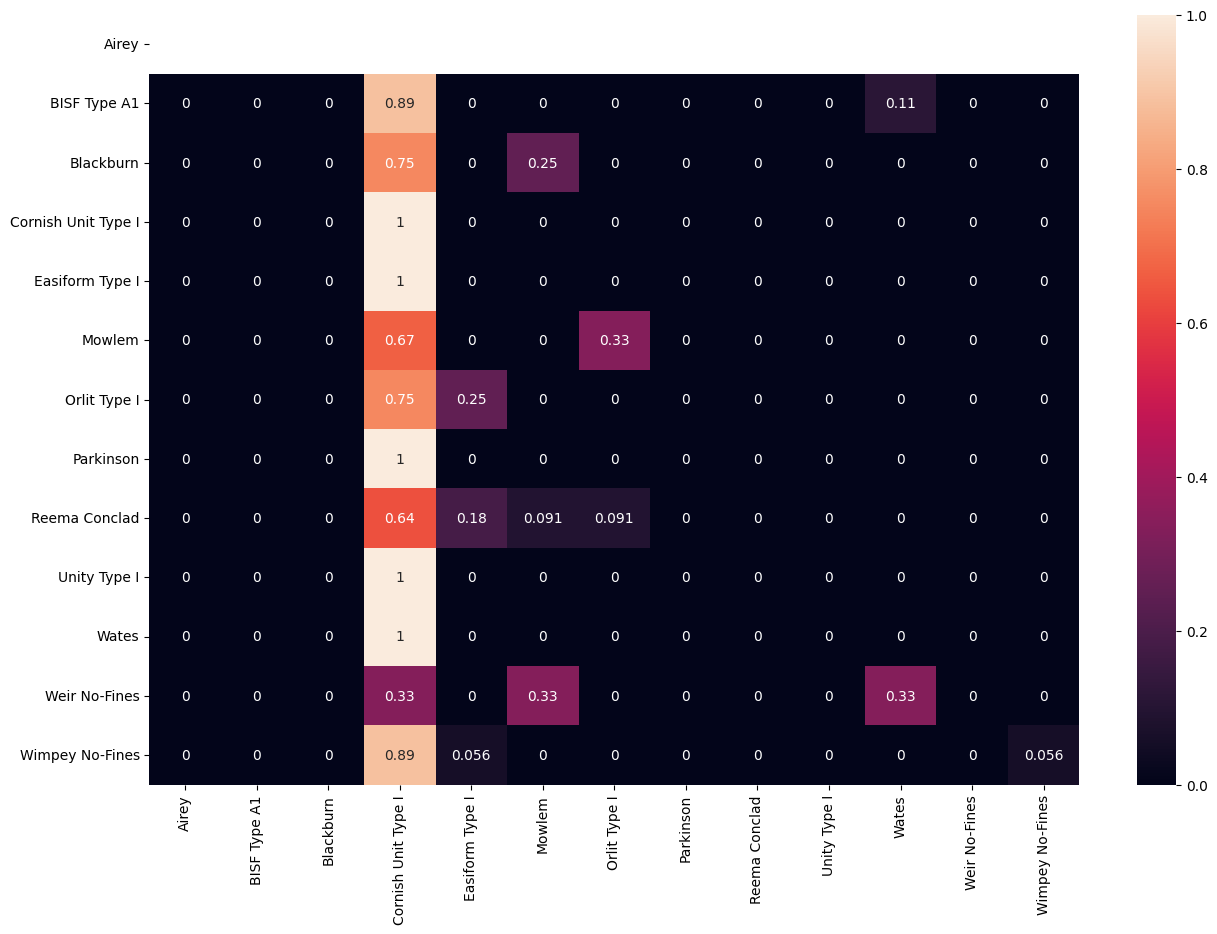

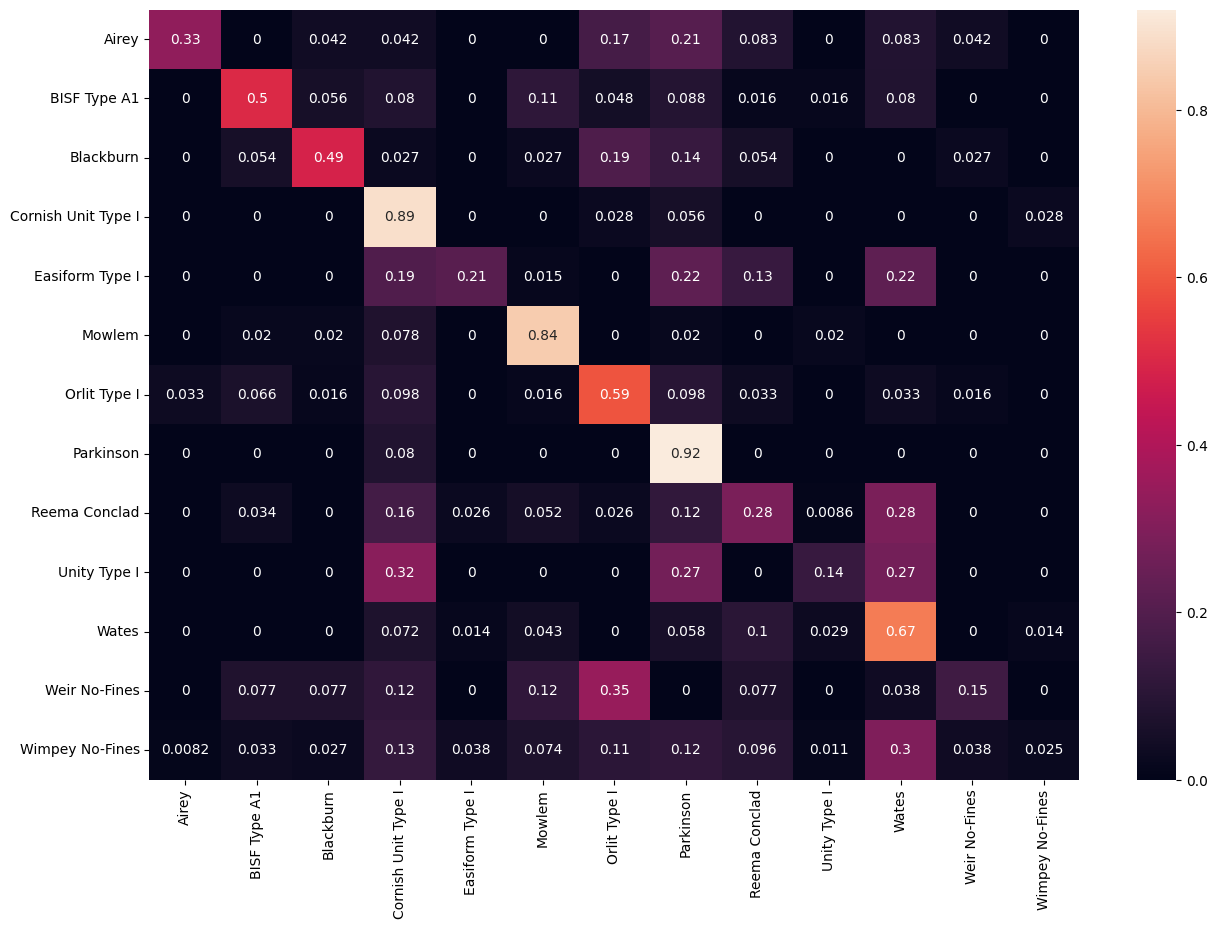

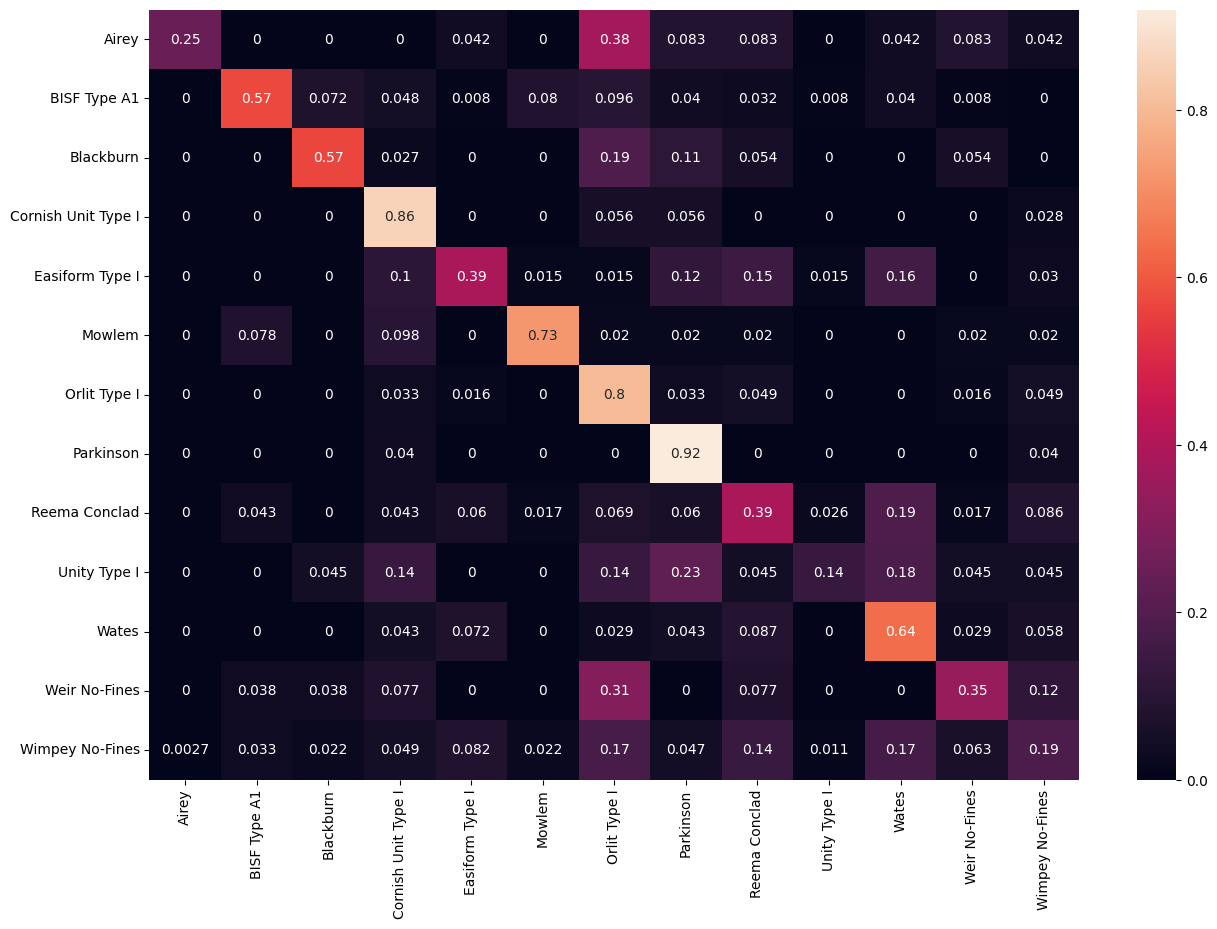

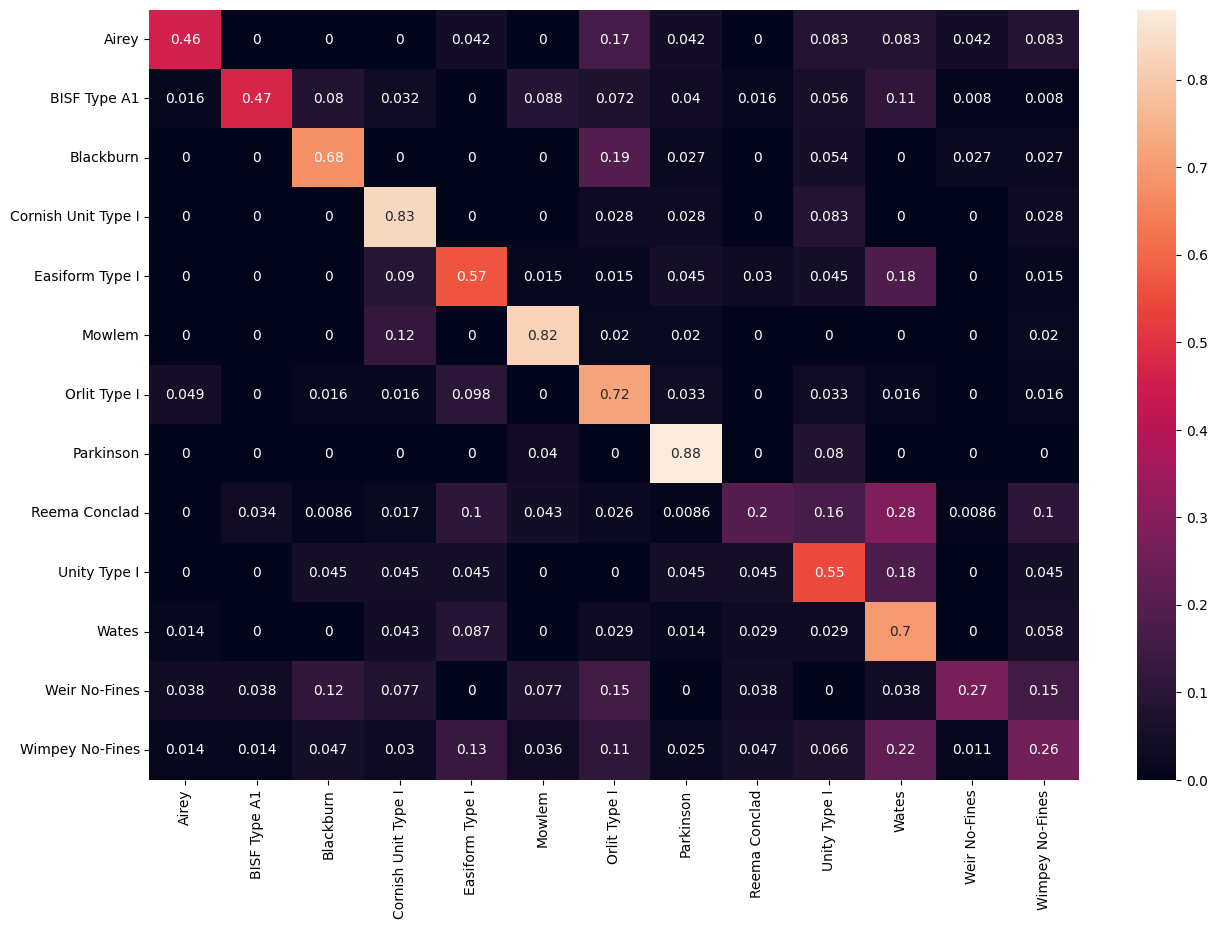

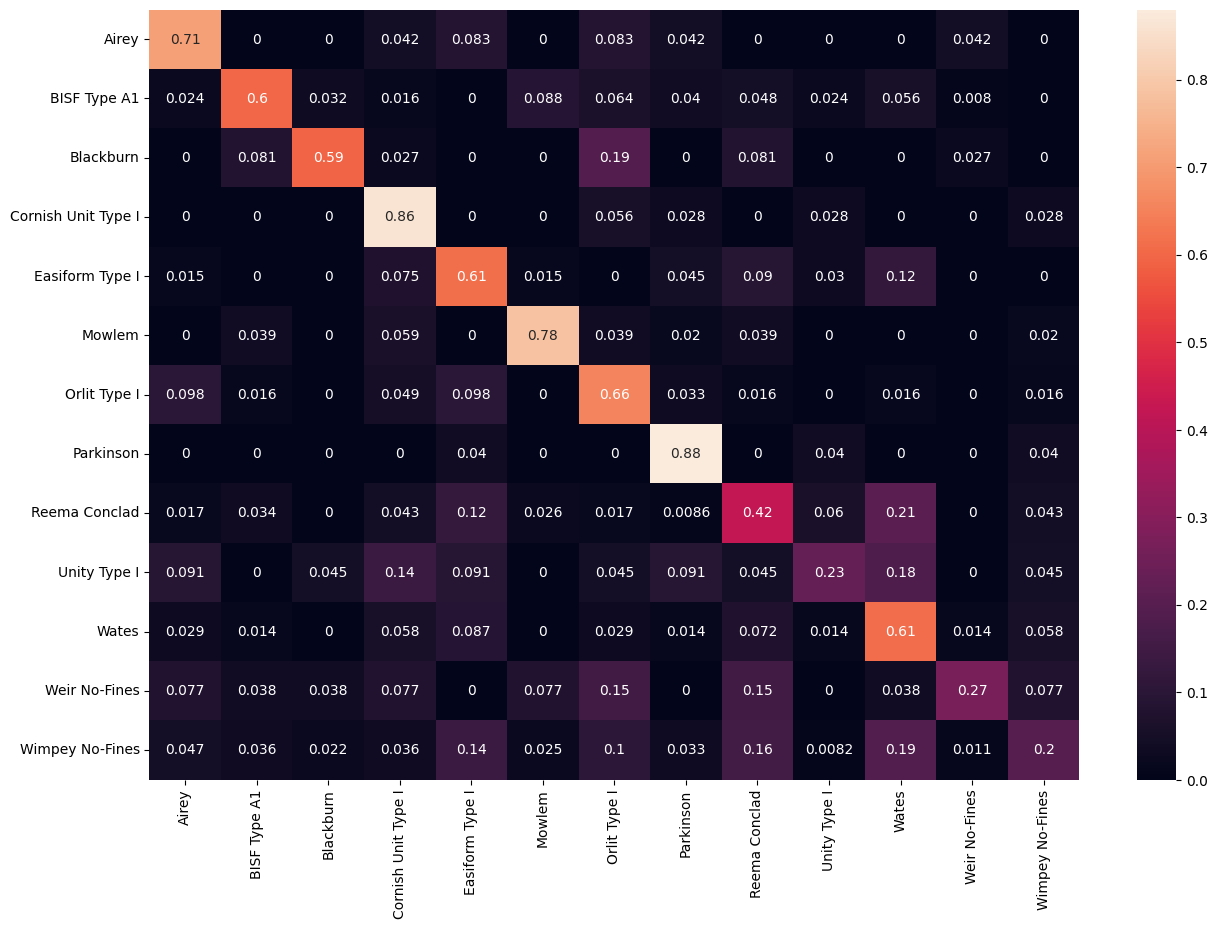

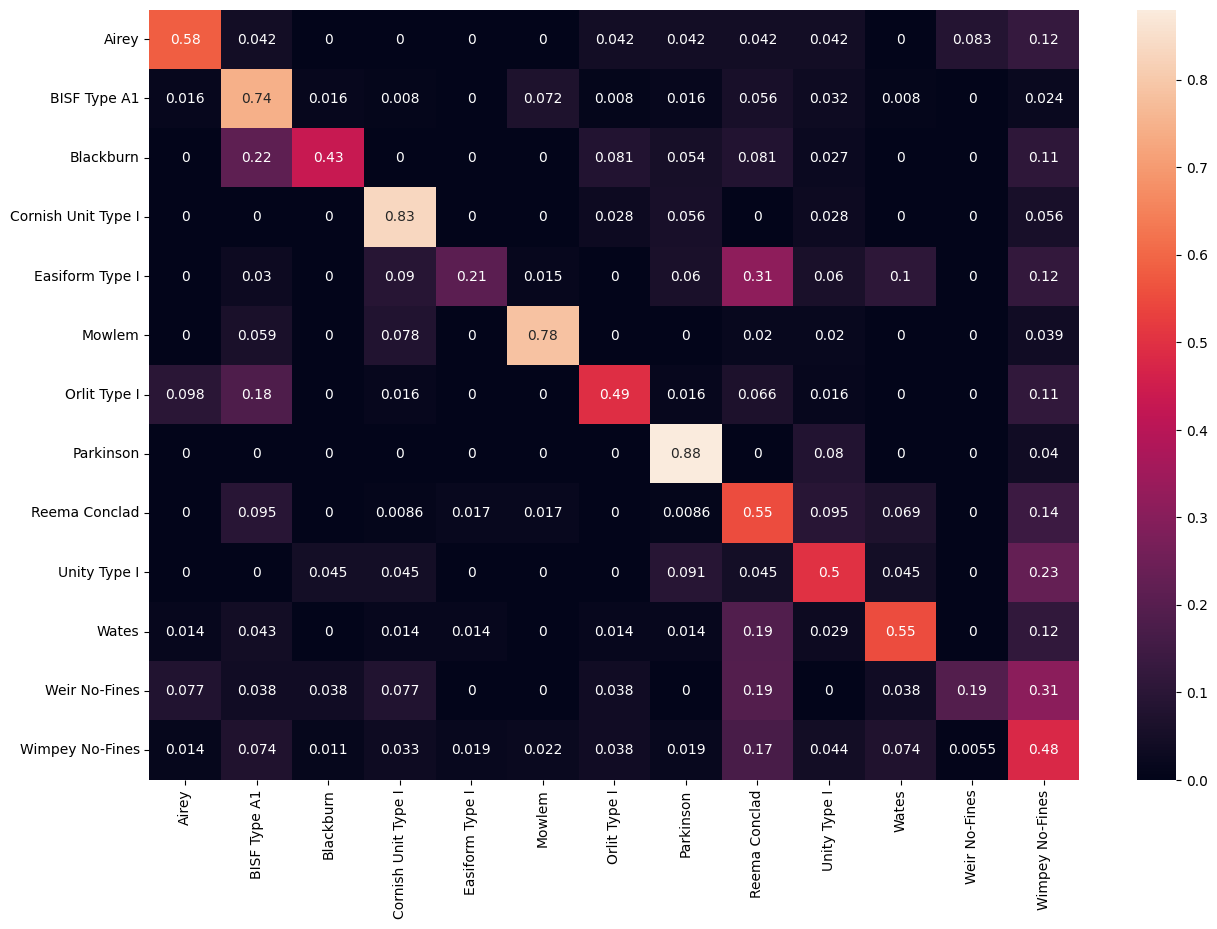

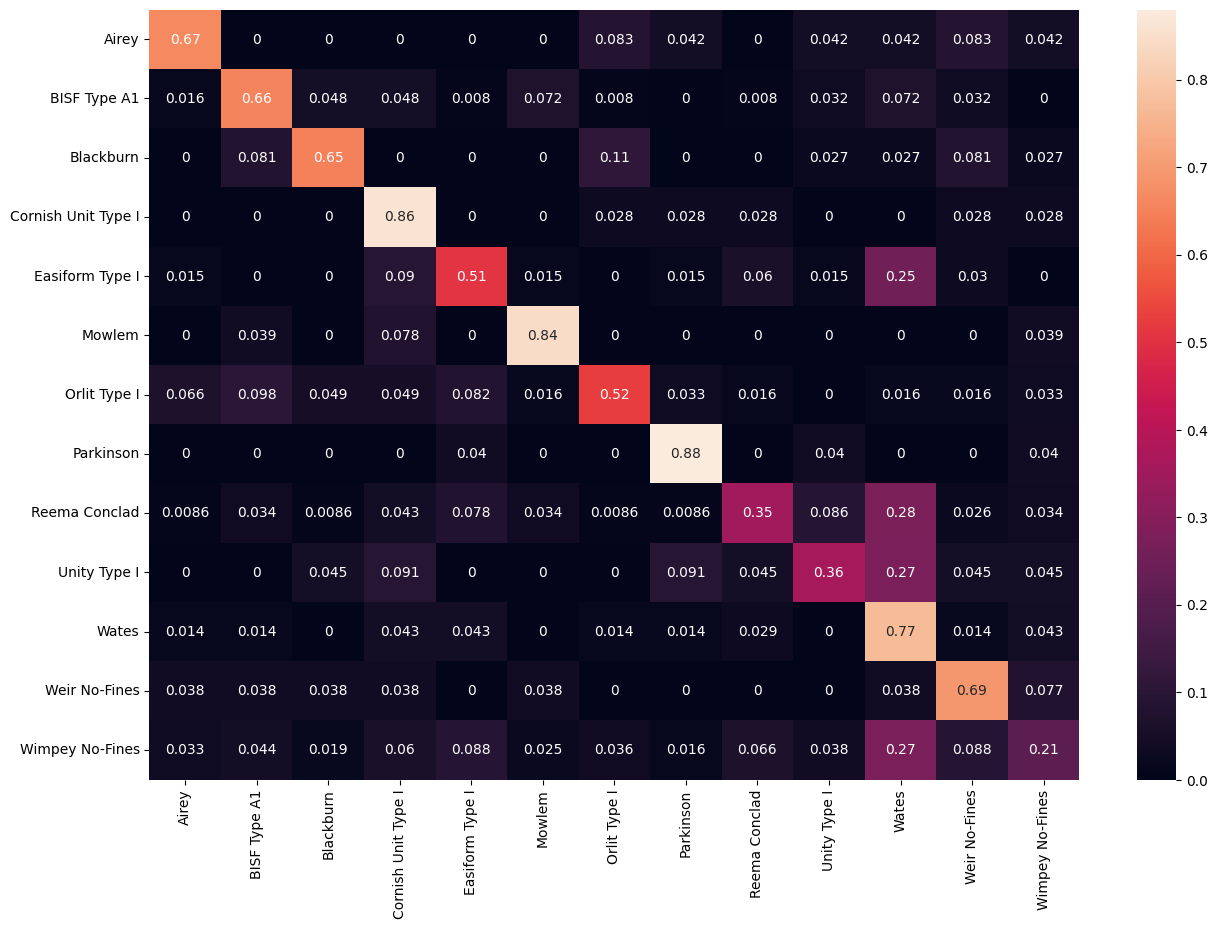

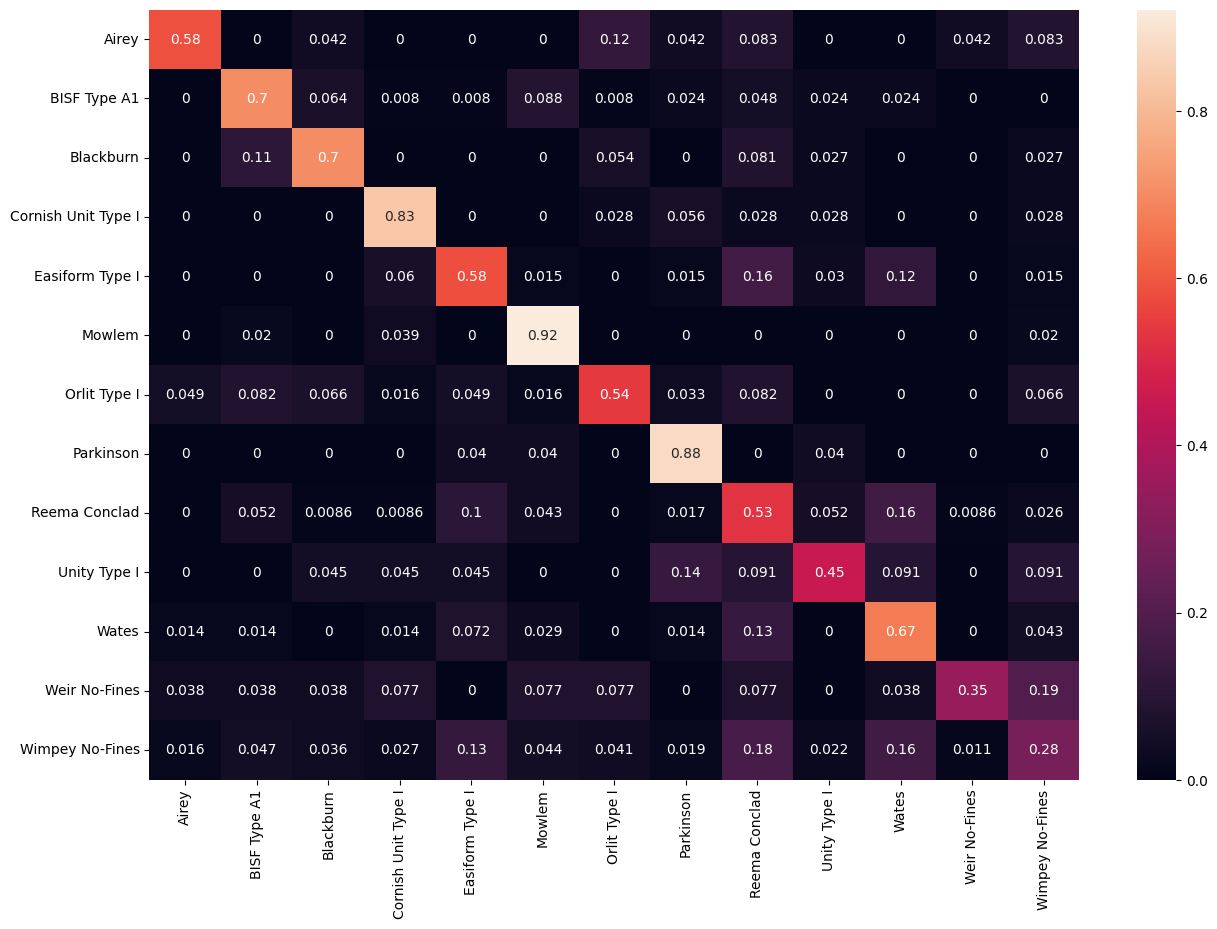

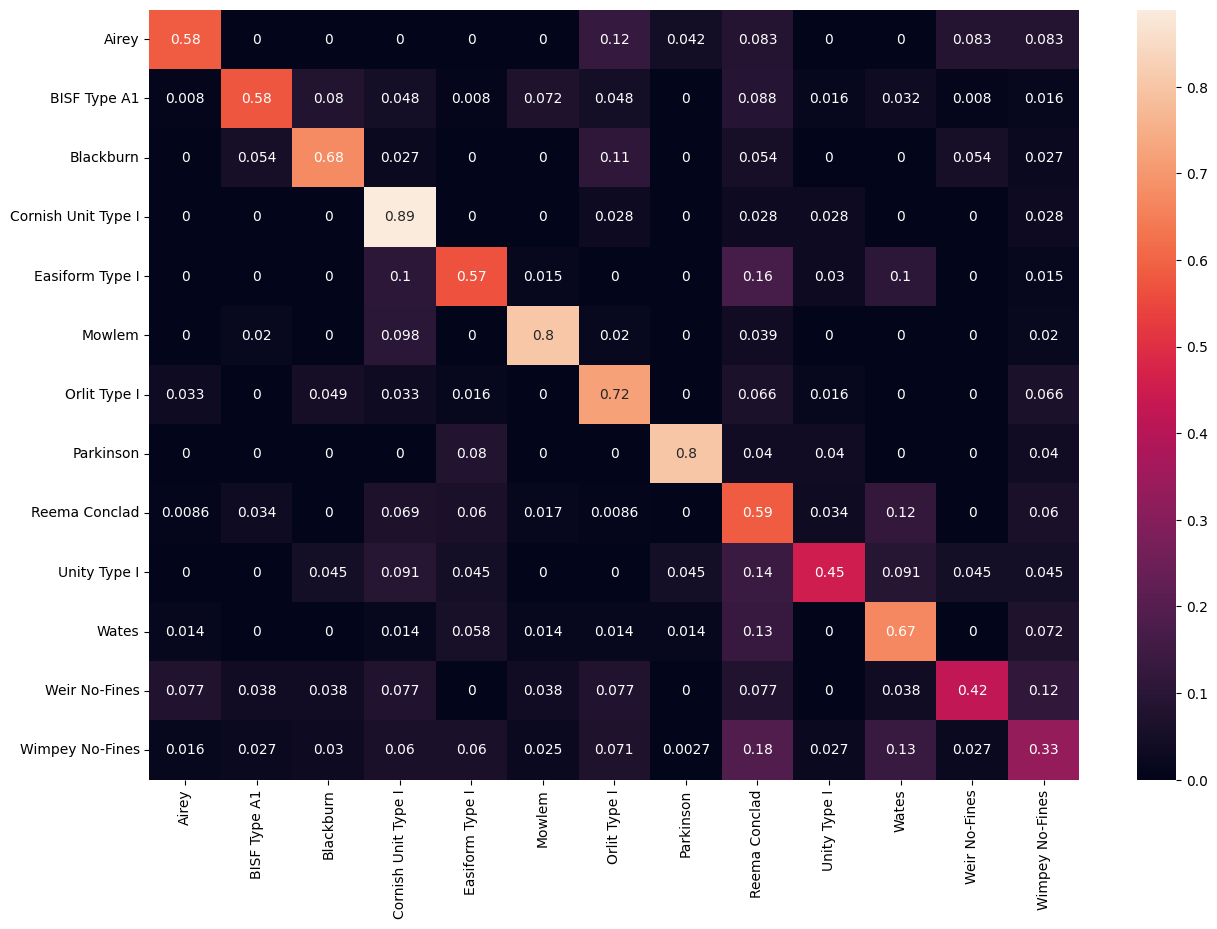

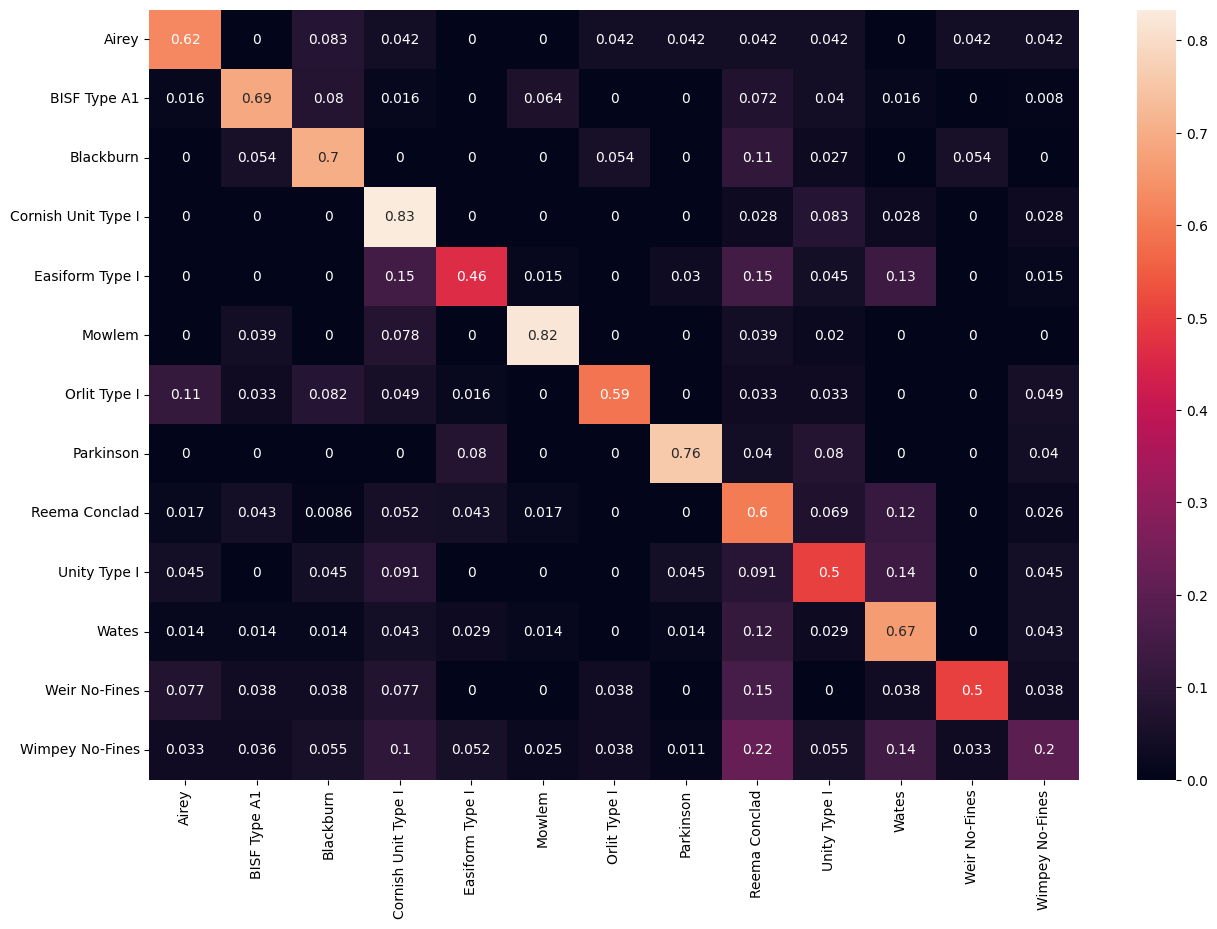

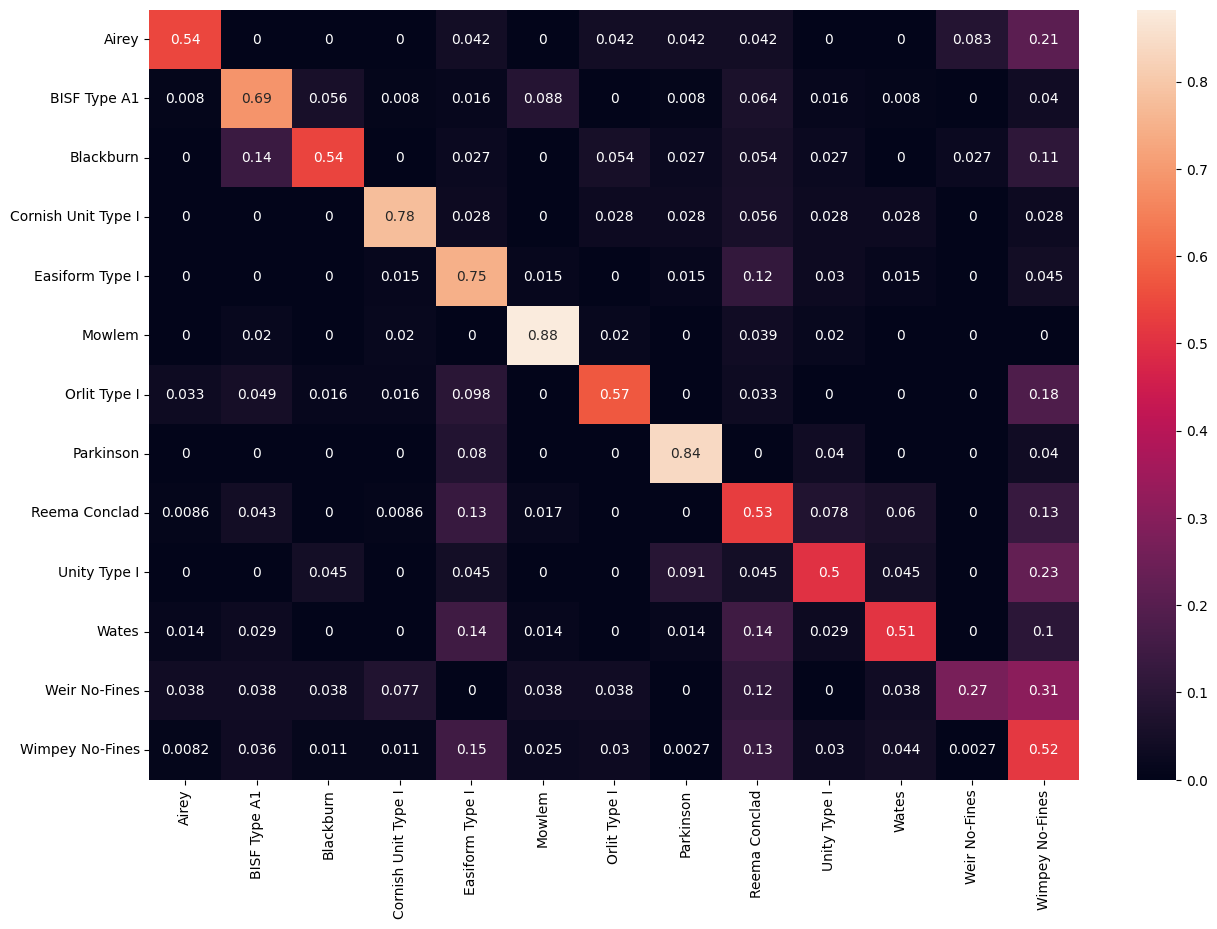

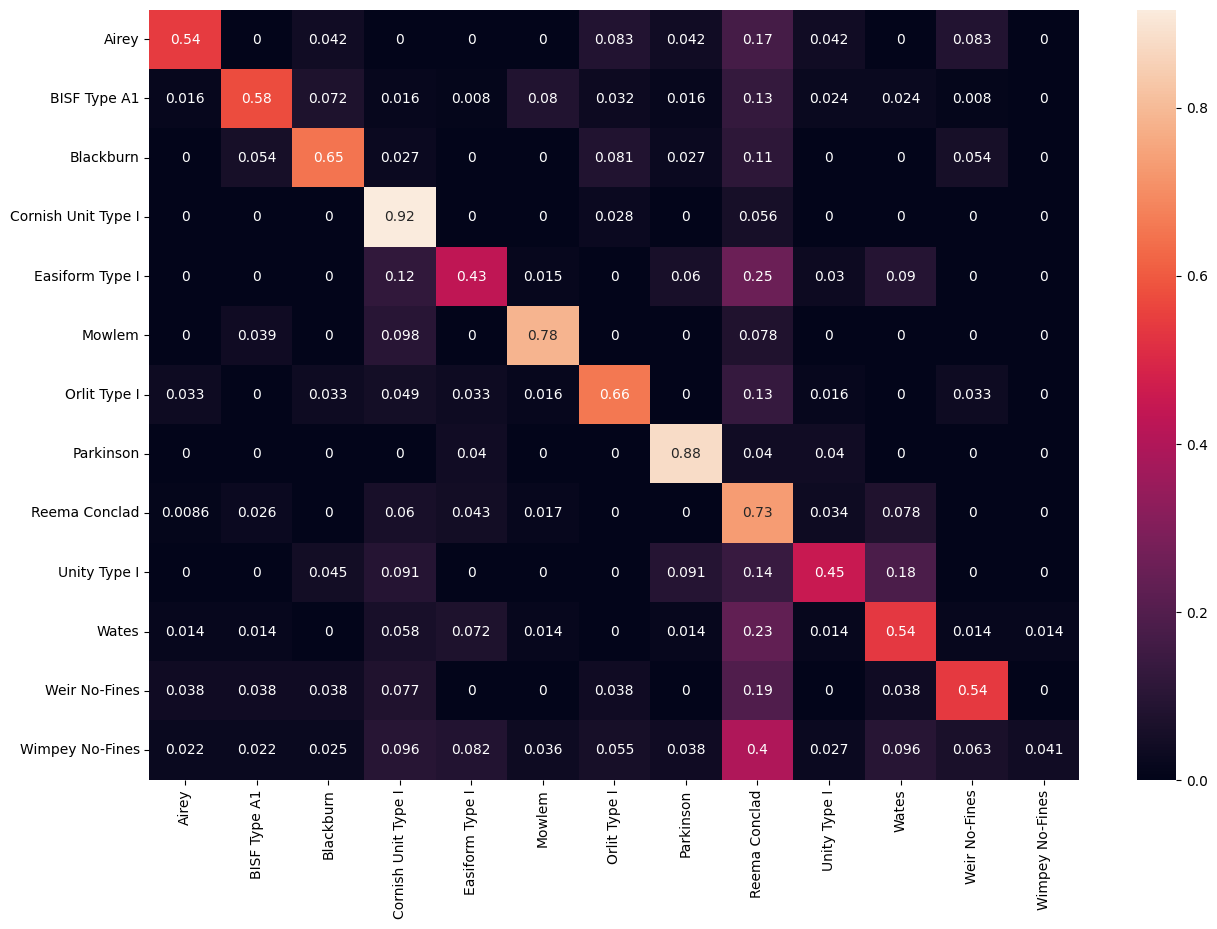

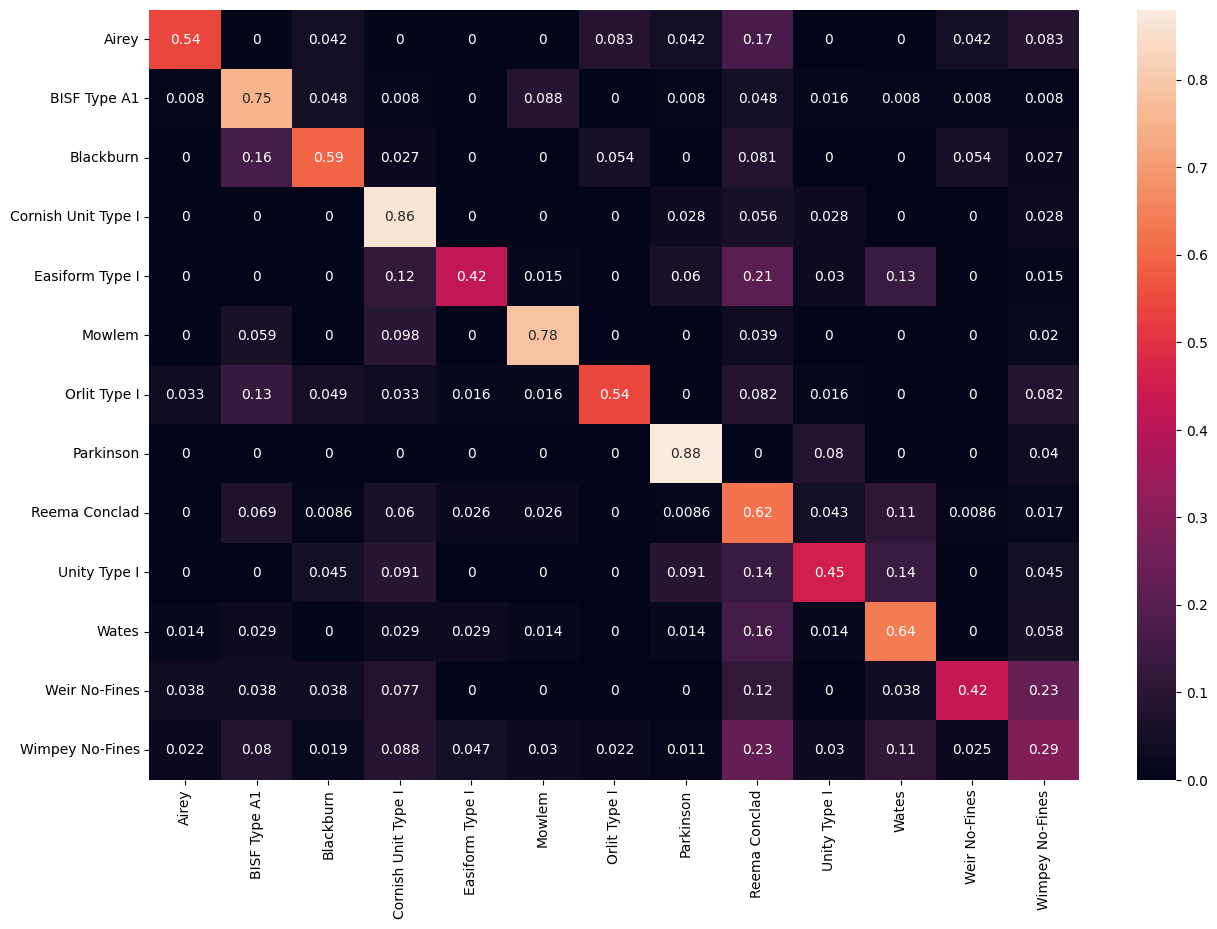

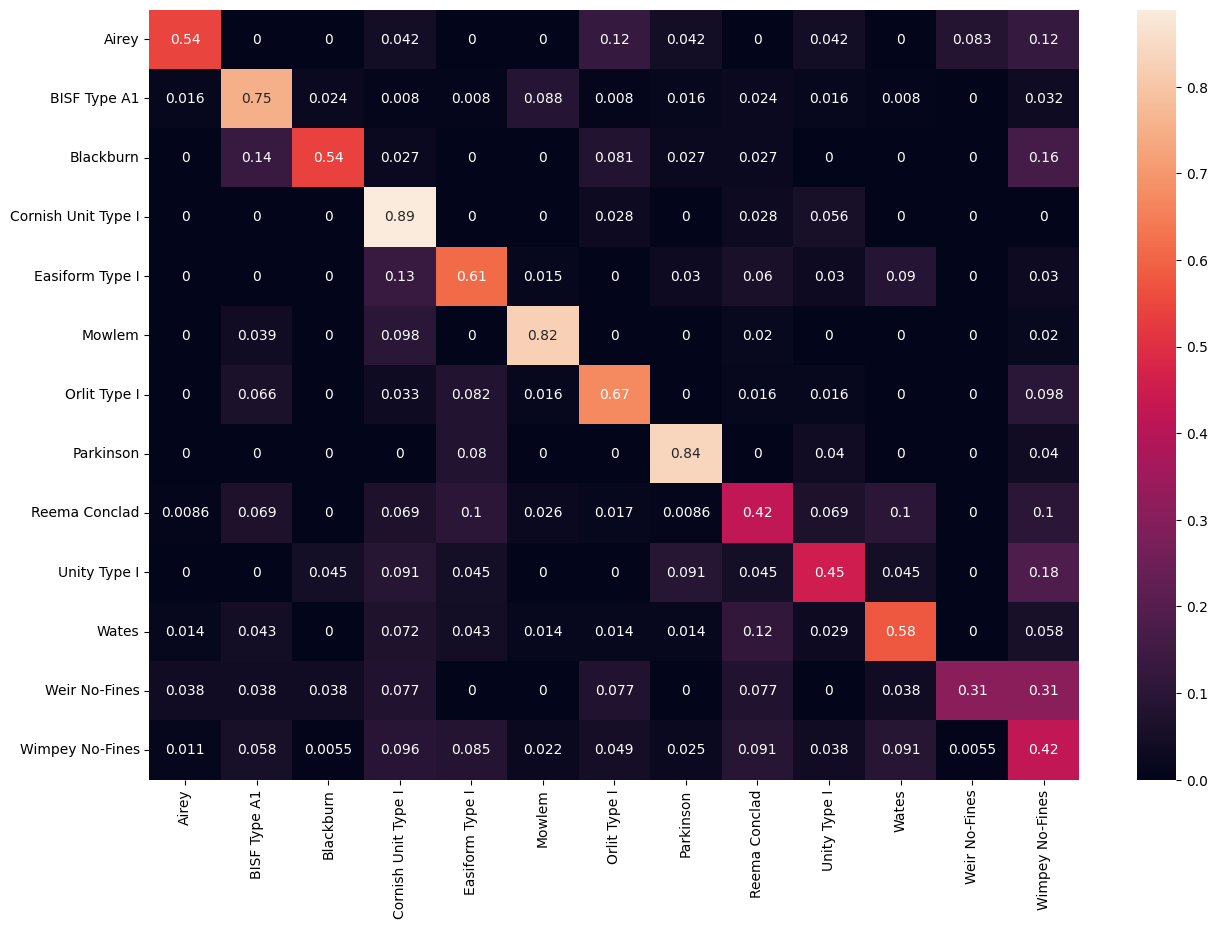

In [ ]:

#fits model using datamodule provided
trainer.fit(model, dm)

In [ ]:

checkpoint_callback = ModelCheckpoint(dirpath="/content/lightning_logs/9whljbrm/checkpoints", monitor="val_acc")

trainer = pl.Trainer(callbacks=[checkpoint_callback ])
                        
# trainer.fit(model, dm)
checkpoint_callback.best_model_path

In [22]:
#test trained model on test dataloader 
trainer.test(dataloaders = dm.test_dataloader(), ckpt_path='best')
# wandb.finish()

num samples 6825
Num train:4777 Num val:1023 Num test:1025
Total num: 6825  total sum: 6825
starting labels


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at ./lightning_logs/slckw50e/checkpoints/epoch=9-step=1500.ckpt


starting samplers
Data modules for predict only


INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at ./lightning_logs/slckw50e/checkpoints/epoch=9-step=1500.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6282926797866821     │
│         test_jacc         │    0.3817792534828186     │
│         test_loss         │    1.1151740550994873     │
│      test_precision       │    0.47515663504600525    │
│        test_recall        │    0.49191564321517944    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.1151740550994873,
  'test_acc': 0.6282926797866821,
  'test_recall': 0.49191564321517944,
  'test_precision': 0.47515663504600525,
  'test_jacc': 0.3817792534828186}]

In [23]:

wandb.finish()

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
test_acc,▁
test_jacc,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_acc_epoch,▁▄▅▆▆▇▇▇▇▇███
train_acc_step,▂▂▂▂▅▁▄▄▇▃▄▂▅▅▅▆▄▄▅▆▅▅▅▁▆▅▅▆▅▇▆▅█▆▆▁▅▆▅
train_jacc_epoch,▁▄▅▆▆▆▇▇▇██▇█
train_jacc_step,▂▃▁▄▆▁▄▅▂▅▅▁▆▆▃▇▆▂▇▇▃▆▆▂██▃▇▆▄▆▆▅▇▇▁▆▇▃
train_loss,█▅▄▆▄▄▃▄▃▃▂▃▄▃▄▃▂▃▁▂▂▂▁▂▂▂▃▂▃▃▂▁▁▂▃▂▂▁▃▂


In [ ]:
# PATH = '/content/gdrive/MyDrive/Non_Trads_FOI/models/resnet_zany-firebrand-166.pt'
# torch.save(model.state_dict(), PATH)

In [ ]:

PATH = '/content/gdrive/MyDrive/Non_Trads_FOI/models/tusken-midichlorian-170.pt'
torch.save(model.state_dict(), PATH)

In [ ]:

len(os.listdir("/content/gdrive/MyDrive/Non_Trads_FOI/data/cambridge_svi/cambridge1/"))

In [ ]:


# new = MyDataModule(data_dir="/content/gdrive/MyDrive/Non_Trads_FOI/data/full_svi/sandbox_images", batch_size=32, pred_only = True)
# new.setup()

In [ ]:
# trainer.predict(model, dataloaders =dm.test_dataloader)

# Make predictions with model

In [ ]:
#should I filter facades first? yes 
pred_dm = MyDataModule(data_dir="/content/gdrive/MyDrive/Non_Trads_FOI/data/cambridge_svi/sandbox_cam/", batch_size=32, pred_only = True, svi_raw=False)
pred_dm.setup()

['Wimpey No-Fines', 'Reema Conclad', 'BISF Type A1', 'Mowlem', 'Timber Frame (UK)', 'Orlit Type I', 'Easiform Type I', 'Wates', 'Weir No-Fines', 'Blackburn', 'Cornish Unit Type I', 'Airey', 'Concrete   ', 'Bison Trimline', 'Unity Type I', 'Shepherd', 'EDLO BRS', 'Parkinson', 'Aberdeen Corporation', 'Belfry']
list of raw samples is 5
len samples : 5
num samples 5
Data modules for predict only
Pred only, num of samples = 5


num corrupt 0


In [ ]:

preds = trainer.predict(model, dataloaders =  pred_dm.predict_dataloader())


Num train:4 Num val:1 Num test:2
Total num: 7  total sum: 7
Data modules for predict only


Predicting: 0it [00:00, ?it/s]

In [ ]:
df.to_csv('preds.csv')

In [ ]:
def extract_predictions(trainer, model , pred_dm, pred_data,  df_path = None, ):
    preds = trainer.predict(model, dataloaders =  pred_dm.predict_dataloader())

    idx_dict = pred_dm.get_dataset_dict()

    list_toids= []
    
    for x in pred_dm.get_dataset_samples():
      if pred_data =='cam_svi':
        toid = x[0].split('/')[-1].split('_')[0] 
        list_toids.append(toid)

    preds = [x.item()  for x in preds[0]]
    class_preds = [idx_dict[str(x)] for x in preds]
                  
    df = pd.DataFrame( {'TOID_id': list_toids , 'Preds_int' : preds, 'Pred_class': class_preds   })
    
    if df_path is not None:
      df.to_csv(df_path)
    return df 

In [ ]:

pred_df = extract_predictions(trainer, model, pred_dm, pred_data='cam_svi', )

Num train:4 Num val:1 Num test:2
Total num: 7  total sum: 7
Data modules for predict only


Predicting: 0it [00:00, ?it/s]

,TOID_id,Preds_int,Pred_class
0,0001000010181854,4,Timber Frame (UK)
1,0001000010181859,1,Reema Conclad
2,0001000010181875,4,Timber Frame (UK)
3,0001000010181850,4,Timber Frame (UK)
4,0001000010181866,11,Airey


In [ ]:
data_loader = DataLoader(...)
model = MyModel()
trainer = Trainer()
predictions = trainer.predict(model, data_loader)

In [ ]:
PATH = '/content/gdrive/MyDrive/Non_Trads_FOI/models/resnetadam.pt'
model.load_state_dict(torch.load(PATH))
model.eval()
list_output=[]

for x in test_dm.test_dataloader():
   output = model(x[0])
   x = torch.argmax(output, dim=1)
   x= torch.flatten(x)
   list_output.append(x)

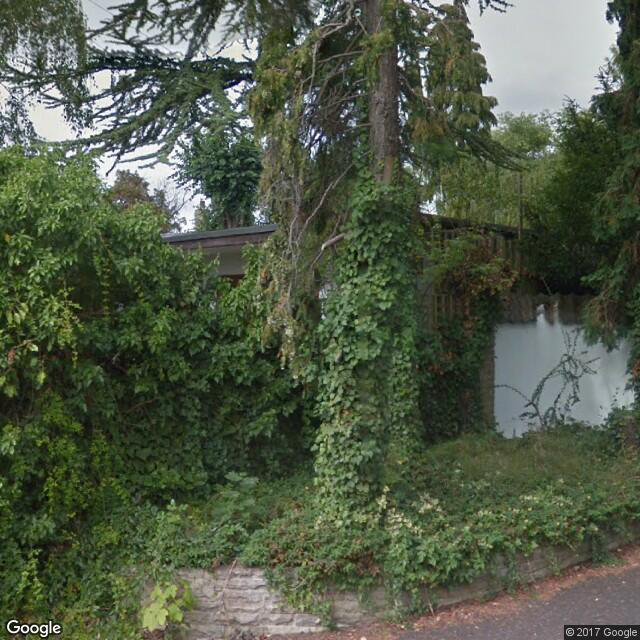

In [ ]:
from PIL import Image
f = '/content/gdrive/MyDrive/Non_Trads_FOI/data/cambridge_svi/cambridge1/0001000010181876_WMZdFfWA0C4ntRtBS5iYTw.jpg'
Image.open(f)

In [ ]:
# if model_out_path is not None:
#   torch.save(model.state_dict(), model_out_path)

In [ ]:
cdf = pd.read_csv('raw_nums.csv')
cdf.set_index('Unnamed: 0', inplace=True)

# norm =  np.sum(cdf, axis=1)
# cdf = cdf/norm



# sn.heatmap(cdf, annot=True)
# plt.figure(figsize = (25,17))



In [ ]:

cdf

In [ ]:

cdf
292+ 80 +44+14+17+24+39+9+72

In [ ]:

precision = correctly pred pos / all pred pos 
micro: true pos and false pos then calc precision 
macro: calc precision per class and average them 

In [ ]:

true_positives

In [ ]:

np.sum(cdf, axis=0)

In [ ]:

false_positives

In [ ]:

import numpy as np



# calculate true positives and false positives for each class
true_positives = np.diag(cdf)
false_positives = np.sum(cdf, axis=0) - true_positives

# calculate micro-precision
micro_precision = np.sum(true_positives) / (np.sum(true_positives) + np.sum(false_positives))

print("Micro-Precision: {:.15f}".format(micro_precision))


# calculate total correct predictions
total_correct = np.trace(cdf)

# calculate total predictions
total_predictions = np.sum(cdf).sum()

# calculate accuracy
accuracy = total_correct / total_predictions

print("Accuracy: {:.15f}".format(accuracy))


true_positives = np.diag(cdf)
false_negatives = np.sum(cdf, axis=1) - true_positives

# calculate micro-recall
micro_recall = np.sum(true_positives) / (np.sum(true_positives) + np.sum(false_negatives))

print("Micro-Recall: {:.15f}".format(micro_recall))


In [ ]:
conf_matrix = cdf
# calculate true positives and false positives for each class
true_positives = np.diag(conf_matrix)
false_positives = np.sum(conf_matrix, axis=0) - true_positives

# calculate macro-precision and micro-precision
macro_precision = np.mean(true_positives / (true_positives + false_positives))

# calculate true positives and false negatives for each class
true_positives = np.diag(conf_matrix)
false_negatives = np.sum(conf_matrix, axis=1) - true_positives

# calculate macro-recall and micro-recall
macro_recall = np.mean(true_positives / (true_positives + false_negatives))

# calculate accuracy
total_correct = np.trace(conf_matrix)
total_predictions = np.sum(conf_matrix).sum()
accuracy = total_correct / total_predictions

print("Macro-Precision: {:.4f}".format(macro_precision))
print("Macro-Recall: {:.4f}".format(macro_recall))
print("Accuracy: {:.4f}".format(accuracy))

In [ ]:
tp = 292 
fp= 39 + 22+1+4+16+2+14+4 

tp / (tp+fp)


In [ ]:

591 / 755

In [ ]:

0.7828

In [ ]:

cdf.sum(axis=1)

In [ ]:

f, ax = plt.subplots(figsize = (15,10)) 

sn.heatmap(cdf, annot=True, ax=ax)



In [ ]:


sn.heatmap(cdf, annot=True)
plt.figure(figsize = (25,17))



In [ ]:
listodx = sum(all_labels, [])


In [ ]:

dl = dm.val_dataloader()

In [ ]:

dl = dm.test_dataloader()


all_labels = []
for x in dl:
  images, labels = x
  all_labels.append(labels.tolist())

rdf = pd.DataFrame()
rdf['labels'] =  sum(all_labels, [])
rdf['name'] = [cl_dict[str(x)] for x in rdf['labels'] ]

rdf.groupby('name').count()

In [ ]:


dl = dm.val_dataloader()

all_labels = []
for x in dl:
  images, labels = x
  all_labels.append(labels.tolist())

rdf = pd.DataFrame()
rdf['labels'] =  sum(all_labels, [])
rdf['name'] = [cl_dict[str(x)] for x in rdf['labels'] ]

rdf.groupby('name').count()

In [ ]:

dl = dm.train_dataloader()

all_labels = []
for x in dl:
  images, labels = x
  all_labels.append(labels.tolist())

rdf = pd.DataFrame()
rdf['labels'] =  sum(all_labels, [])
rdf['name'] = [cl_dict[str(x)] for x in rdf['labels'] ]

rdf.groupby('name').count()

In [ ]:


# def extract_predictions(dm, model, output_location = None):
#     #Extract the Ground truth and Predictions 
#     list_output = []
#     predictions = []

#     test_dataloader = dm.predict_dataloader()
  

#     # for batch in test_dataloader:
#     #   data = sample[0]
#     # print('Ground truth list created')

#     test_ids = dm.samples[0]
#     # print('Num of Test IDs is {}, Num of Ground Truth labels is {}'.format(len(test_ids), len(ground_truth)) )


#     model.eval()
#     for x in dm.test_dataloader():
#       output = model(x[0])
#       x = torch.argmax(output, dim=1)
#       x= torch.flatten(x)
#       list_output.append(x)

#     for x in list_output:
#       x= x.tolist()
#       # print(x)
#       for y in x:
#         predictions.append(y)
#     print('Prediction list created')

#     # #create df of predictions and save 
#     df = pd.DataFrame( {'TestId': test_ids , 'Preds' : predictions   })

#     return df 

In [ ]:

test_dataset= dm.test_dataloader

for sample in test_dataset:
      label = sample[1]
      data = sample[0]

In [ ]:

test_dataset

In [ ]:
#creates predictions and if output_location not None, saves them 
extract_predictions(dm, model, base_dir)

In [ ]:
import pandas as pd
import os

In [ ]:

file_names

['0001000010179994_qthaBW-NYhzdtGxm0WcIeA.jpg',
 '0001000010180004_GVVXQckroqn5nxf-9zmktw.jpg',
 '0001000010180011_LANLhZ6Ga7weUr8ay-KMGA.jpg',
 '0001000010180010_LANLhZ6Ga7weUr8ay-KMGA.jpg',
 '0001000010180005_KNT-drpmpFaFMY_2B9MA7A.jpg',
 '0001000010180018_sikgaHxk8lImCfRA-RLOPg.jpg',
 '0001000010180007_JR8MgqCQZ2x32UnKAeyg0Q.jpg',
 '0001000010180002_WSmrZCiLgNSoJj4_ohficw.jpg',
 '0001000010180008_8dal6cZGmXt2iyFide0Y7A.jpg',
 '0001000010180006_8dal6cZGmXt2iyFide0Y7A.jpg',
 '0001000010180013_sikgaHxk8lImCfRA-RLOPg.jpg',
 '0001000010180009_8dal6cZGmXt2iyFide0Y7A.jpg',
 '0001000010180003_uF-9YdJ7jw9BJquB5_2VbA.jpg',
 '0001000010180014_JBWAus_jgmWaOvU9C7XOvQ.jpg',
 '0001000010180022_gVkdj0tvLLIod8CkjRjcPw.jpg',
 '0001000010180017_JBWAus_jgmWaOvU9C7XOvQ.jpg',
 '0001000010180016_JBWAus_jgmWaOvU9C7XOvQ.jpg',
 '0001000010180023_QI6J29uAsQ7ib_wxG0oBNQ.jpg',
 '0001000010180012_A8C3rQCia12J8luJTsK-rw.jpg',
 '0001000010180015_JBWAus_jgmWaOvU9C7XOvQ.jpg',
 '0001000010180021_KN3e4M55ouSuZC7d-PWk1

In [ ]:
toid = pd.read_csv('/content/gdrive/MyDrive/Non_Trads_FOI/data/cambridge_svi/scores_toid.csv')

# Path to the folder containing the images
folder_path = '/content/gdrive/MyDrive/Non_Trads_FOI/data/cambridge_svi/cambridge1'

# Get a list of all file names in the folder
file_names = os.listdir(folder_path)
t_ids = [ int(x.split('_')[0]) for x in file_names]

In [ ]:
# note confidence can be 1 or 0 
cam_inter_post_war_toids = toid[toid['era'].isin(['d interwar', 'e postwar']) & toid['TOID'].isin(t_ids) ].TOID

In [ ]:
cam_inter_post_war_toids

0        1000009954004
1        1000009954292
2        1000009954310
4        1000009954356
5        1000009954357
             ...      
33787    1000010181853
33788    1000010181854
33793    1000010181866
33794    1000010181871
33797    1000010181876
Name: TOID, Length: 18754, dtype: int64

In [ ]:
scd = StreetViewData("/content/gdrive/MyDrive/Non_Trads_FOI/Facades_SVI")

idx =100
idx=200
idx=2200
path  = scd.samples[idx][0]
label = scd.samples[idx][1]

sample = Image.open(path).convert("RGB")
sample.show()

width , height = sample.size

left = 170
top = 250
right = 430
bottom = 10
print(top, bottom )
im1 = sample.crop((left, bottom, right, top))







im1.show()